In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sales_processing import add_date_features, normalize_sales, denormalize_sales, fill_in_dates
from holiday_processing import add_holidays
from weather_processing import add_weather_info
from covid_processing import add_covid_info


In [103]:
df = pd.read_csv('data/caspecoTrainingData.csv')
weather = pd.read_csv('data/uppsala_weather.csv')
holidays = pd.read_csv('data/swedish_holidays.csv')
dates = pd.date_range('2020-01-01', '2023-01-04')
covid = pd.read_csv('data/Folkhalsomyndigheten_Covid19.csv')
from sklearn.preprocessing import normalize
# normalize sales for each company using sklearn normalize
sales = df.copy()
sales['Sales'] = sales.groupby('Company')['Sales'].transform(lambda x: normalize(x.values.reshape(1, -1)).reshape(-1))
sales = fill_in_dates(sales, dates)
sales = add_date_features(sales)
sales = add_holidays(sales, holidays)
sales = add_weather_info(sales, weather)
sales = add_covid_info(sales, covid)
sales.columns = sales.columns.str.title()
sales.head()

,Date,Company,Sales,Day,Week,Month,Year,Weekday,Weekend,Workday,Holiday,Temp,Conditions,Totalt_Antal_Fall,Uppsala
0,2020-01-01,0,0.000000,1,1,1,2020,2,0,1,1,3.3,1,0.0,0.0
1,2020-01-01,1,0.000000,1,1,1,2020,2,0,1,1,3.3,1,0.0,0.0
2,2020-01-01,2,0.004759,1,1,1,2020,2,0,1,1,3.3,1,0.0,0.0
3,2020-01-02,0,0.016313,2,1,1,2020,3,0,1,0,6.0,1,0.0,0.0
4,2020-01-02,1,0.032005,2,1,1,2020,3,0,1,0,6.0,1,0.0,0.0


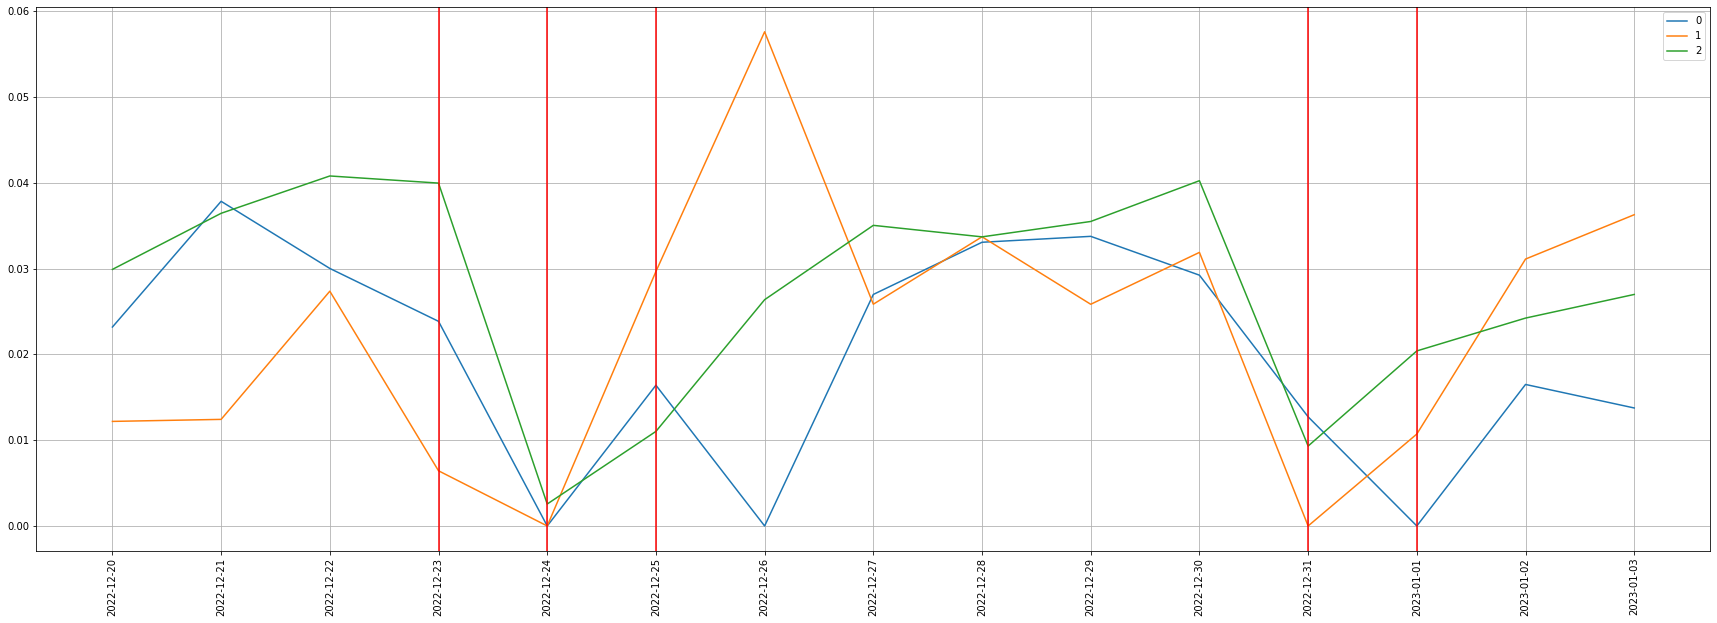

In [104]:
startdate = '2022-12-20'
enddate = '2023-01-03'

datefiltered = sales[(sales['Date'] >= startdate) & (sales['Date'] <= enddate)]
filteredholiday = holidays[(holidays['Date'] >= startdate) & (holidays['Date'] <= enddate)]
plt.figure(figsize=(30, 10))
for company in sales['Company'].unique():
    plt.plot(datefiltered['Date'][::3], datefiltered[datefiltered['Company'] == company]['Sales'], label=company)
# set xticks to every date
plt.xticks(datefiltered['Date'][::3], rotation=90)
# plot holidays as vertical lines
for holiday in filteredholiday['Date']:
    holiday = pd.to_datetime(holiday)
    plt.axvline(x=holiday, color='red')
plt.grid()
plt.legend()
plt.show()

Weekend       0.268586
Week          0.203359
Year          0.173749
Company       0.141107
Month         0.074072
Day           0.054793
Weekday       0.044991
Holiday       0.024856
Conditions    0.014487
dtype: float64
0.8550860026713677


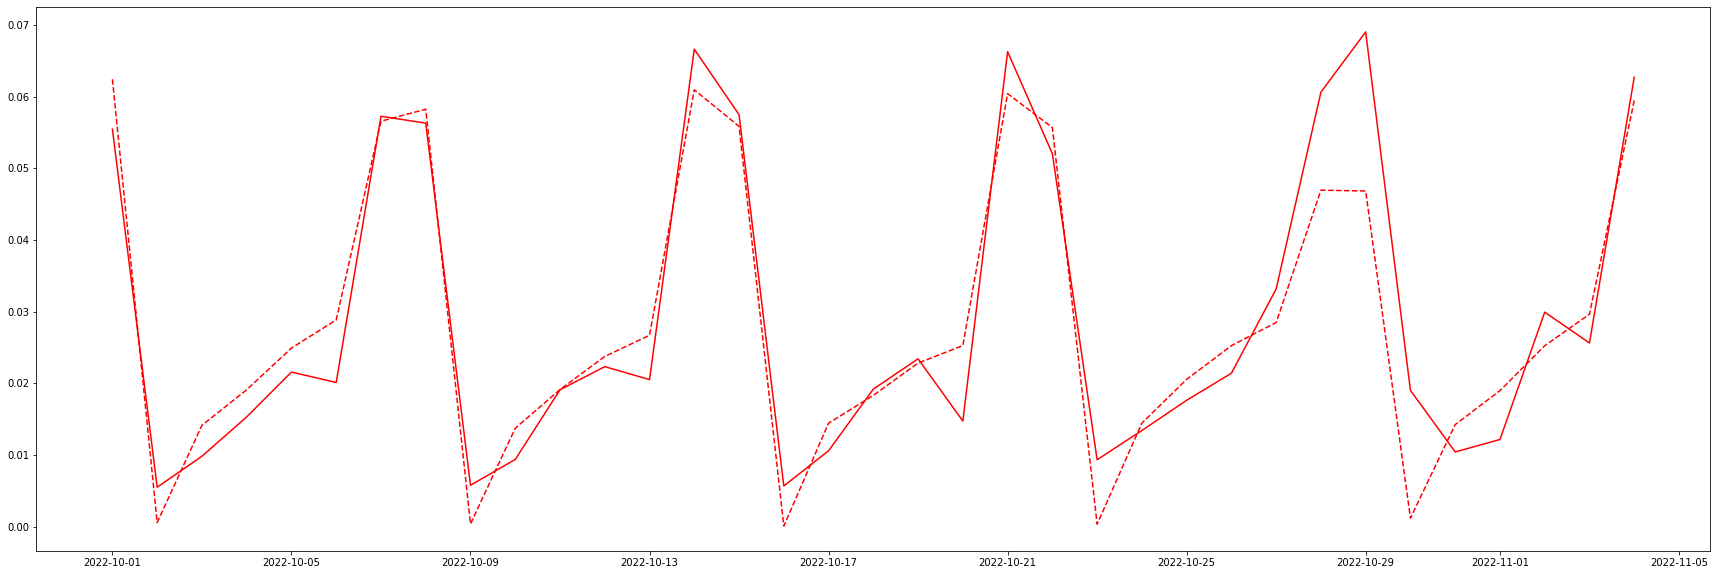

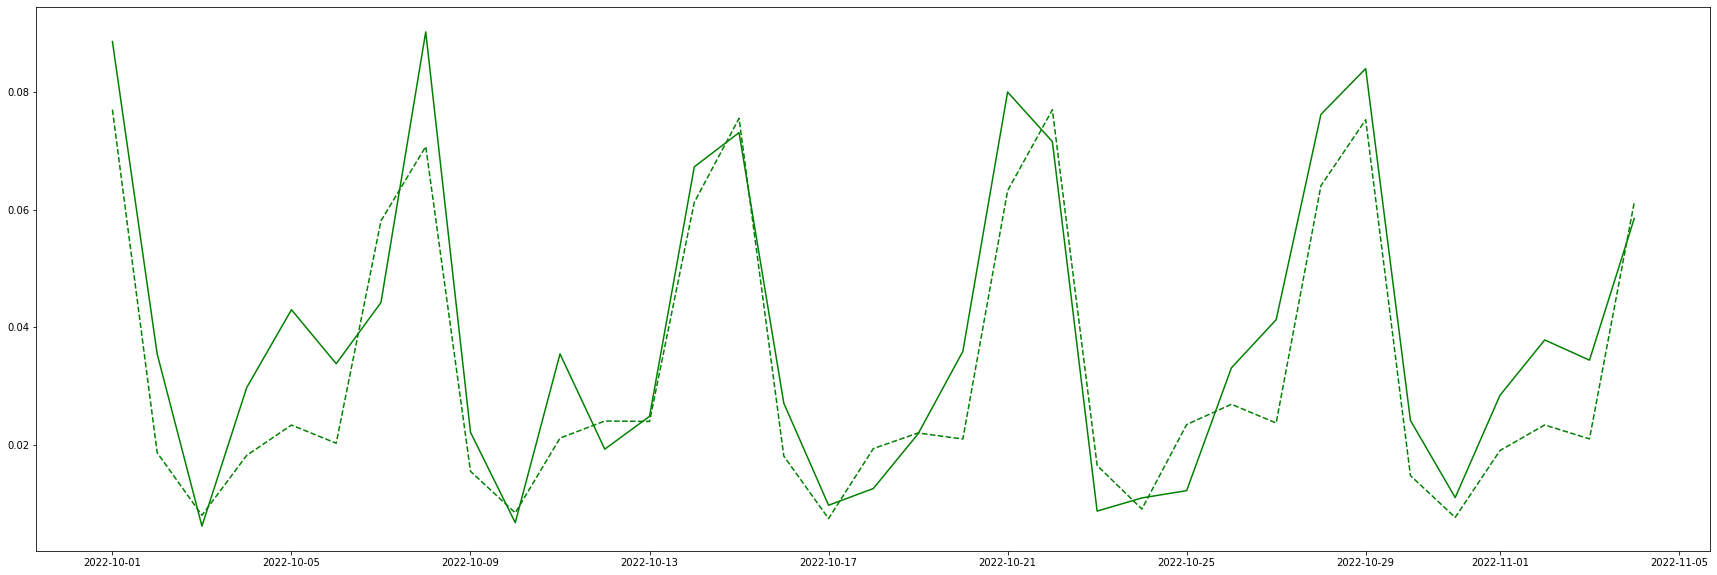

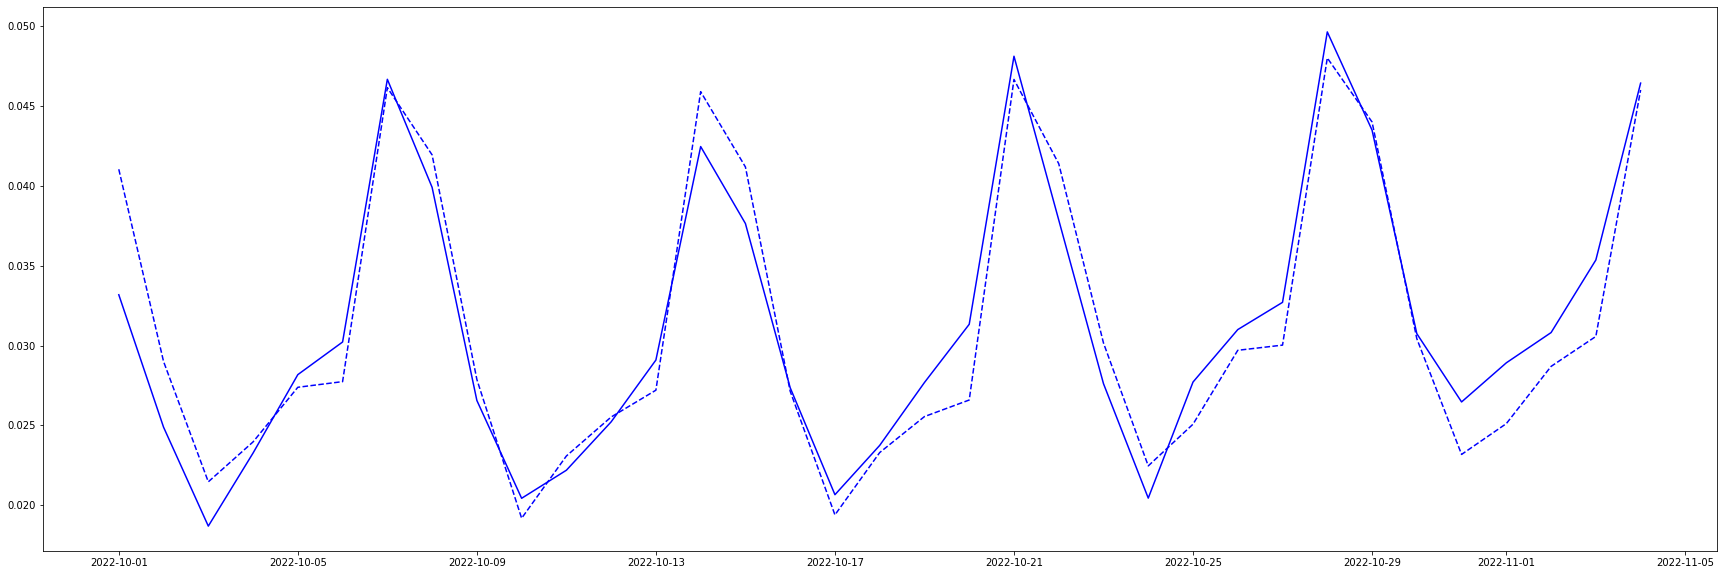

In [107]:
from sklearn.ensemble import RandomForestRegressor

dropcols = ['Workday', 'Totalt_Antal_Fall', 'Temp', 'Uppsala']
imp_sales = sales.drop(columns=dropcols)

teststart = '2022-10-01'
testend = '2022-11-04'

imp_dates = sales['Date'][(sales['Date'] >= teststart) & (sales['Date'] <= testend)].unique()

X_train = imp_sales[sales['Date'] < teststart]
X_train = X_train.drop(columns=['Date'])
y_train = X_train['Sales']
X_train = X_train.drop(columns=['Sales'])
X_test = imp_sales[(sales['Date'] >= teststart) & (sales['Date'] <= testend)]
X_test = X_test.drop(columns=['Date'])
y_test = X_test['Sales']
X_test = X_test.drop(columns=['Sales'])



model = RandomForestRegressor(random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

feature_importance = pd.Series(model.feature_importances_,
          index=X_train.columns).sort_values(ascending=False)
print(feature_importance)
print(model.score(X_test, y_test))
#print score
colors = {0: 'red', 1: 'green', 2: 'blue'}

for company in [0,1,2]:
  plt.figure(figsize=(30, 10))
  company_dates = sales['Date'][(sales['Company'] == company) & (sales['Date'] >= teststart) & (sales['Date'] <= testend)]
  company_sales = y_test[X_test['Company'] == company]
  plt.plot(company_dates, company_sales, label=f'{company} actual', color=colors[company])
  plt.plot(company_dates, y_pred[X_test['Company'] == company],
          label=f'{company} predicted', linestyle='--', color=colors[company])
  
    

In [117]:
from sklearn.model_selection import cross_val_score, cross_val_predict

scores = cross_val_score(model, sales.drop(columns=['Date','Sales']), sales['Sales'], cv=20)
print(scores)

[ 0.78867503  0.77007078  0.61873305 -0.82911422 -0.11312059  0.07910234
  0.07484112  0.68024064  0.71613439  0.38545457  0.10980633  0.68279846
  0.60165516  0.07171457  0.54840967  0.5701757   0.38242717  0.61722578
  0.81170383  0.37368191]
